In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

import pandas_profiling as pp
%matplotlib inline 

## Load Data

In [118]:
#dict for dtypes
dtypes = {'gender':'category', 'diabetes':'category','hypertension':'category','smoking history':'category',
          'stroke':'category' ,'heart disease':'int64'}

df_data_raw = pd.read_csv('/data/MQIC_Patient_Data_100k_Sample.csv',
                      dtype=dtypes)

## Data Cleaning and Exploratory Data Analysis

Data cleaning...
47825 of 100000 lines dropped


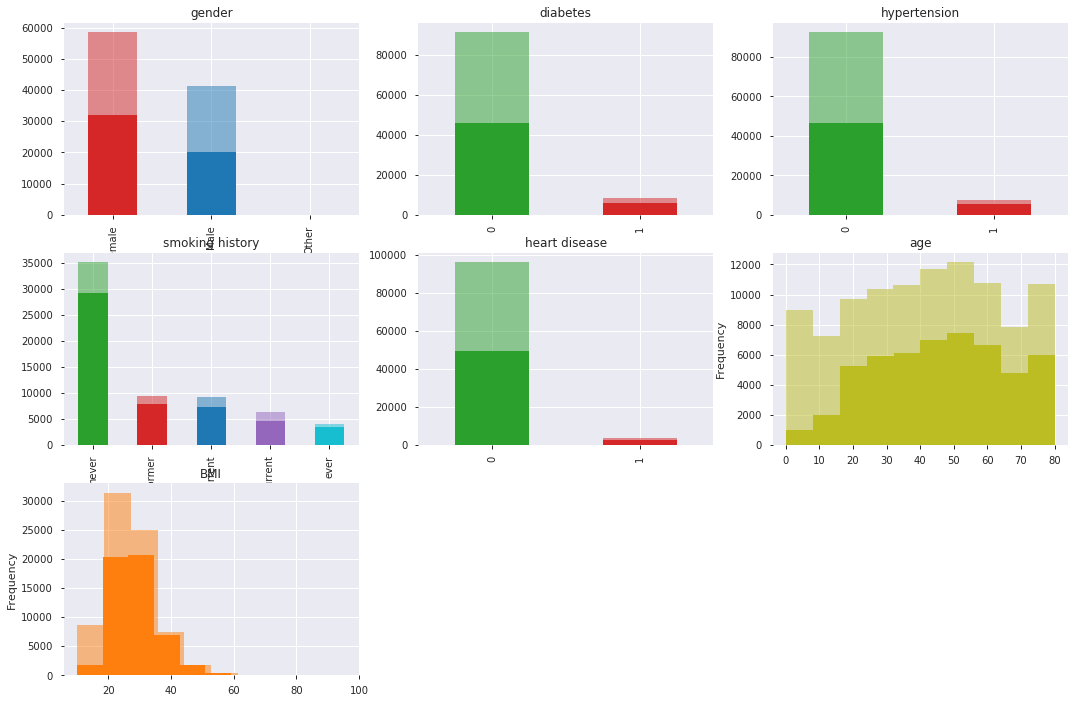

In [132]:
print('Data cleaning...')
entries_before = df_data_raw.shape[0]
df_data = df_data_raw.dropna(axis=0, how='any')
entries_after = df_data.shape[0]
dropped = entries_before - entries_after
print(f'{dropped} of {entries_before} lines dropped')

fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(18,12))
df_data_raw['gender'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,0], alpha=0.5, title='gender')
df_data['gender'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,0], title='gender')

df_data_raw['diabetes'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'], ax=axes[0,1],alpha=0.5, title='diabetes')
df_data['diabetes'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'], ax=axes[0,1], title='diabetes')

df_data_raw['hypertension'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[0,2],alpha=0.5, title='hypertension')
df_data['hypertension'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[0,2], title='hypertension')

df_data_raw['smoking history'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:cyan'],ax=axes[1,0],alpha=0.5, title='smoking history')
df_data['smoking history'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:cyan'],ax=axes[1,0], title='smoking history')

df_data_raw['heart disease'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[1,1],alpha=0.5, title='heart disease')
df_data['heart disease'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[1,1], title='heart disease')

df_data_raw['age'].plot(kind='hist',title='age', color='tab:olive',ax=axes[1,2], alpha=0.5)
df_data['age'].plot(kind='hist',title='age', color='tab:olive',ax=axes[1,2])

df_data_raw['BMI'].plot(kind='hist',title='BMI', color='tab:orange', ax=axes[2,0], alpha=0.5)
df_data['BMI'].plot(kind='hist',title='BMI', color='tab:orange', ax=axes[2,0])

fig.delaxes(axes[2][2])
fig.delaxes(axes[2][1])



## Data Wrangling

In [18]:
#rearrange df
df_data = df_data[['gender','age','diabetes','hypertension','stroke',
                   'smoking history','BMI', 'heart disease']]
#input variables X
X = df_data[['gender','age','diabetes','hypertension','stroke',
                   'smoking history','BMI']]
#output variable y
y = df_data['heart disease']

## Data Preparation

In [19]:
categorial = df_data[['gender', 'diabetes', 'hypertension', 'stroke', 'smoking history']].values

#onehotencode categorical data, i.e. every col except age and BMI

# TODO: maybe drop one hot encoding. Is one hot encoding necessary?
#one hot encode  categorical cols (see categorial) --> prep for xgboost
encoded_X = None
for i in range(0, categorial.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(categorial[:,i])
    feature = feature.reshape(categorial.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    feature = onehot_encoder.fit_transform(feature)
    #add feature to encoded_X
    if encoded_X is None:
        encoded_X = feature
    else:
        encoded_X = np.concatenate((encoded_X, feature), axis=1)


#add 'age','BMI'
numeric_cols = ['age', 'BMI']
for col in numeric_cols:
    values = X[col].values
    values = values.reshape(values.shape[0],1)
    encoded_X = np.concatenate((encoded_X, values), axis=1)
    
#reshape output variables
reshaped_y = y.values
reshaped_y = reshaped_y.reshape(y.shape[0],) 
     
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, reshaped_y, test_size = 0.2)

## Model

In [8]:
#fit model
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy: 94.94%


## Feature Importance

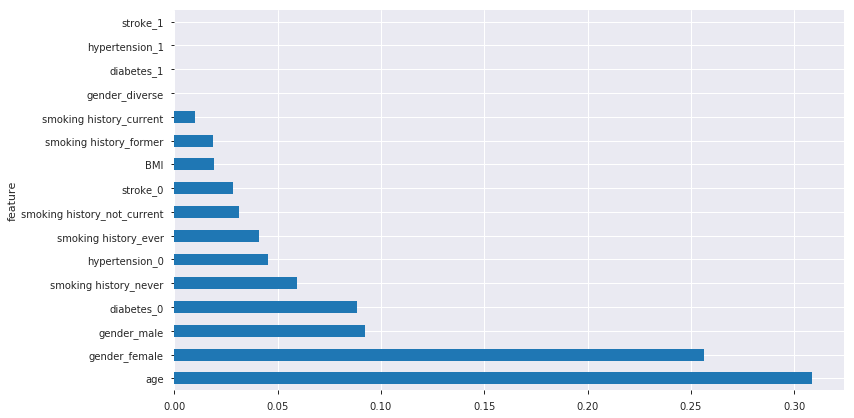

In [43]:
#encoded_X col labels:  
labels = ['gender_female', 'gender_male', 'gender_diverse', 'diabetes_0', 'diabetes_1',
        'hypertension_0','hypertension_1', 'stroke_0', 'stroke_1', 
        'smoking history_current', 'smoking history_ever', 'smoking history_former', 
        'smoking history_never', 'smoking history_not_current','age', 'BMI']  

df_enc = pd.DataFrame(encoded_X)
df_enc.columns = labels

def feature_imp(df,model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

feature_imp(df_enc ,model).plot('feature', 'importance', kind='barh', figsize=(12,7), legend=False)

## Predict whether or not you suffer from a heart disease